<a href="https://colab.research.google.com/github/nithyasri0913/Algorithmic-Trading/blob/main/algorithmic_trading_Mean_Reversion_Trading_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mean Reversion Trading Strategy

In [42]:
import pandas as pd
import numpy as np
from datetime import datetime 
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [39]:
from google.colab import files
uploaded=files.upload()

Saving SLV.csv to SLV (5).csv


In [43]:
df=pd.read_csv('/content/SLV.csv')
#set date as index
df=df.set_index(pd.DatetimeIndex(df['Date'].values))
#drop date column
df.drop(['Date'], inplace=True, axis=1)
df.head()

,Open,High,Low,Close,Adj Close,Volume
2012-08-27,29.900000,30.240000,29.740000,29.740000,29.740000,13758900
2012-08-28,29.930000,30.000000,29.730000,29.930000,29.930000,6977600
2012-08-29,29.930000,29.950001,29.610001,29.750000,29.750000,8626400
2012-08-30,29.910000,29.920000,29.280001,29.440001,29.440001,11544700
2012-08-31,29.799999,30.799999,29.320000,30.790001,30.790001,28197900


In [44]:
df.shape

(2517, 6)

In [45]:
#calclulate SMA
def SMA(data, period=30, column='Close'):
  return data[column].rolling(window=period).mean()

In [46]:
#build the dataset
df['SMA']=SMA(df,21)
df['Simple_Returns']=df.pct_change(1)['Close']
df['Log_Returns']=np.log(1+df['Simple_Returns'])
df['Ratios']= df['Close']/df['SMA']
df.head()

,Open,High,Low,Close,Adj Close,Volume,SMA,Simple_Returns,Log_Returns,Ratios
2012-08-27,29.900000,30.240000,29.740000,29.740000,29.740000,13758900,NaN,NaN,NaN,NaN
2012-08-28,29.930000,30.000000,29.730000,29.930000,29.930000,6977600,NaN,0.006389,0.006368,NaN
2012-08-29,29.930000,29.950001,29.610001,29.750000,29.750000,8626400,NaN,-0.006014,-0.006032,NaN
2012-08-30,29.910000,29.920000,29.280001,29.440001,29.440001,11544700,NaN,-0.010420,-0.010475,NaN
2012-08-31,29.799999,30.799999,29.320000,30.790001,30.790001,28197900,NaN,0.045856,0.044836,NaN


In [47]:
#statistics on the ratio column
df['Ratios'].describe()

count    2497.000000
mean        0.998051
std         0.043089
min         0.723826
25%         0.974611
50%         0.995523
75%         1.021545
max         1.289209
Name: Ratios, dtype: float64

In [48]:
#get the percentile values
percentiles=[15,20,50,80,85]
#remove NA values in the Ratios column 
ratios=df['Ratios'].dropna()
#get the value of the percentiles
percentile_values=np.percentile(ratios,percentiles)
percentile_values

array([0.95972628, 0.96799074, 0.99552319, 1.02816173, 1.03481507])

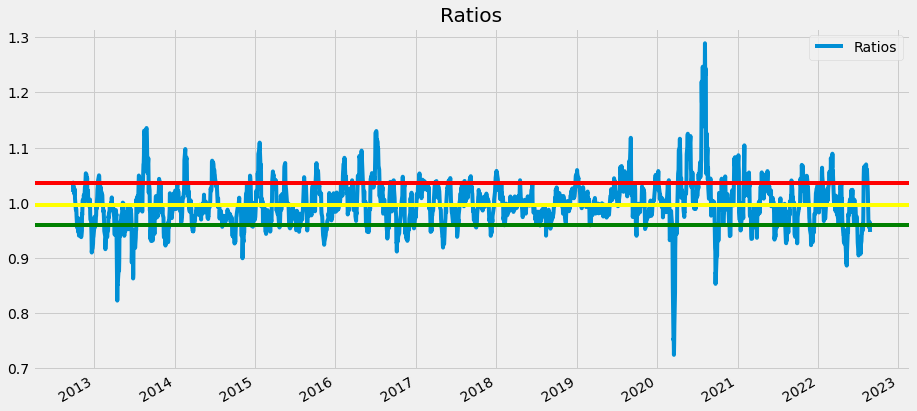

In [49]:
#Plot the ratios
plt.figure(figsize=(14,7))
plt.title('Ratios')
df['Ratios'].dropna().plot(legend=True)
plt.axhline(percentile_values[0], c='green', label='15th percentile')
plt.axhline(percentile_values[2], c='yellow', label='50th percentile')
plt.axhline(percentile_values[-1], c='red', label='85th percentile')

In [50]:
#create buy and sell signals 
sell=percentile_values[-1]
buy=percentile_values[0]
#Put -1 where ratio is greater than the percentile to sell and nan otherwise
df['Positions']=np.where(df.Ratios>sell, -1, np.nan)
#Put -1 where ratio is lesser than the percentile to buy and put the current value otherwise
df['Positions']=np.where(df.Ratios<buy, 1, df['Positions'])
#use ffill to fill the missing values in the data frame- forward fill
df['Positions']=df['Positions'].ffill()

#Get the buy and sell signals
df['Buy']=np.where(df.Positions==1, df['Close'],np.nan)
df['Sell']= np.where(df.Positions==-1, df['Close'],np.nan)

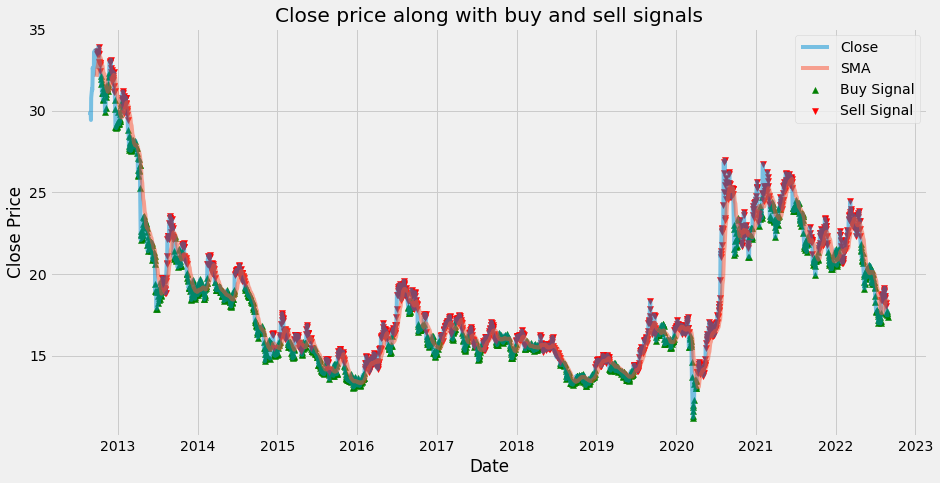

In [51]:
#visualize the buy and sell signals along with the close price
plt.figure(figsize=(14,7))
plt.title('Close price along with buy and sell signals')
plt.plot(df['Close'],alpha=0.5,label='Close')
plt.plot(df['SMA'], alpha=0.5, label='SMA')
plt.scatter(df.index, df['Buy'],color='green', label='Buy Signal',marker='^', alpha=1)
plt.scatter(df.index, df['Sell'],color='red', label='Sell Signal',marker='v', alpha=1)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [52]:
#Calculate the returns
df['Strategy_Returns']=df.Positions.shift(1)*df.Log_Returns
df['Strategy_Returns']

2012-08-27         NaN
2012-08-28         NaN
2012-08-29         NaN
2012-08-30         NaN
2012-08-31         NaN
                ...   
2022-08-22   -0.002853
2022-08-23    0.006834
2022-08-24    0.000567
2022-08-25    0.005656
2022-08-26   -0.021089
Name: Strategy_Returns, Length: 2517, dtype: float64

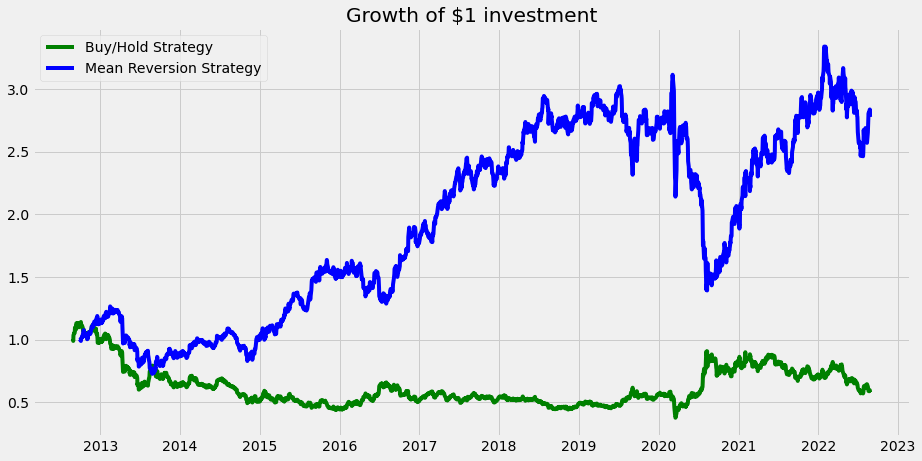

In [53]:
#Plot the cumulative log returns and the cumulative mean reversion strategy
plt.figure(figsize=(14,7))
plt.title('Growth of $1 investment')
plt.plot(np.exp(df['Log_Returns'].dropna()).cumprod(),c='green',label='Buy/Hold Strategy')
plt.plot(np.exp(df['Strategy_Returns'].dropna()).cumprod(),c='blue',label='Mean Reversion Strategy')
plt.legend()

In [54]:
#print the returns for both strategies
print('Buy and Hold Strategy Returns: ', np.exp(df['Log_Returns'].dropna()).cumprod()[-1]-1)
print('Mean Reversion Strategy Returns: ', np.exp(df['Strategy_Returns'].dropna()).cumprod()[-1]-1)

Buy and Hold Strategy Returns:  -0.41627434431741595
Mean Reversion Strategy Returns:  1.7776146502184615
